In [1]:
# dDownload WISDM dataset - Dataset for Human Activity Recognition
# !gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF  --output data/WISDM_ar_latest.tar.gz

In [2]:
#! tar -xvf data/WISDM_ar_latest.tar.gz -C data

In [97]:
# Import libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import sys 
import seaborn as sns
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [55]:
SEED = 45

In [56]:
# Import DL libraries
import tensorflow as tf
from tensorflow import keras


In [57]:
# Import Traditional ML Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [58]:
# ToDO:
# 1. Load the data
# 2. Preprocess the data - Build a Pipeline (Common Data Pipeline)
# 3. Processed Data - Pipeline - Traditional ML Model
# 4. Processed Data - Pipeline - Deep Learning Model
# 5. Post Processing of Results
# 6. Model Evaluation 
# 7. API to send a pack and get the results analysed
# 8. Deploy on Cloud - Package the model and API -Docker
# 9. Optimize the model for Edge - (Tf Lite, ONNX, .h )
# 10. Sample Input and Output Data representations

In [59]:
# Lets work on Raw Data 
# Load Data - Raw data on WISDM is WISDM_ar_v1.1_raw.txt
# Columns - user_id, activity, timestamp, x, y ,z
# Here x y z are the accelerometer readings (Acceleration values)
data_path = "data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt"

# Data as list of lists

def load_data(data_path):
    data = []
    rows =  []
    file = open(data_path, 'r')
    for line in file:
        line = line.split(';')
        data.append(line)
    file.close()
    return data

data = load_data(data_path)

row_length_list = [len(row) for row in data]
print("Unique Row Lengths: ", set(row_length_list))

Unique Row Lengths:  {1, 2, 3}


In [60]:
# As you can see there are sometimes 1 and 2 and 3 row length that means there are some mistake in the data like line mixing
# To handle it lets use regex to split the data 
# We know that the data is in the format of user_id, activity, timestamp, x, y, z so (6 columns - Datatypes - int, string, int, float, float, float) 
# Separated by commas and semicolons 
# ==> Remove risk of reduction of data because of multiple lines in the same row

import re

def clean_data(input_path, output_path):
    with open(input_path, 'r') as infile , open(output_path, 'w') as outfile:
        data = infile.read()
        pattern = re.compile(r'(\d+),(\w+),(\d+),(-?\d+\.\d+),(-?\d+\.\d+),(-?\d+\.\d+)')
        matches = pattern.findall(data)
        for match in matches:
            outfile.write(','.join(match) + '\n')
    print("Data Cleaned and Saved to: ", output_path)

cleaned_data_path = data_path.split(".txt")[0] + "_cleaned.txt"
clean_data(data_path, cleaned_data_path)

Data Cleaned and Saved to:  data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw_cleaned.txt


In [61]:
# Read the cleaned data without shortening the float values
df = pd.read_csv(cleaned_data_path, header=None, names=["user_id", "activity", "timestamp", "x", "y", "z"] , dtype={"user_id": int, "activity": str, "timestamp": int, "x": float, "y": float, "z": float})

In [62]:
print("Shape of the Data: ", df.shape)

Shape of the Data:  (1066467, 6)


In [64]:
# Drop rows where the timestamp is null or zero
df = df.dropna()
df = df[~(df["timestamp"] == 0)]

In [66]:
# Sort data by timestamp and user
df = df.sort_values(by = ['user_id', 'timestamp'], ignore_index=True)

In [67]:
df.head()

,user_id,activity,timestamp,x,y,z
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


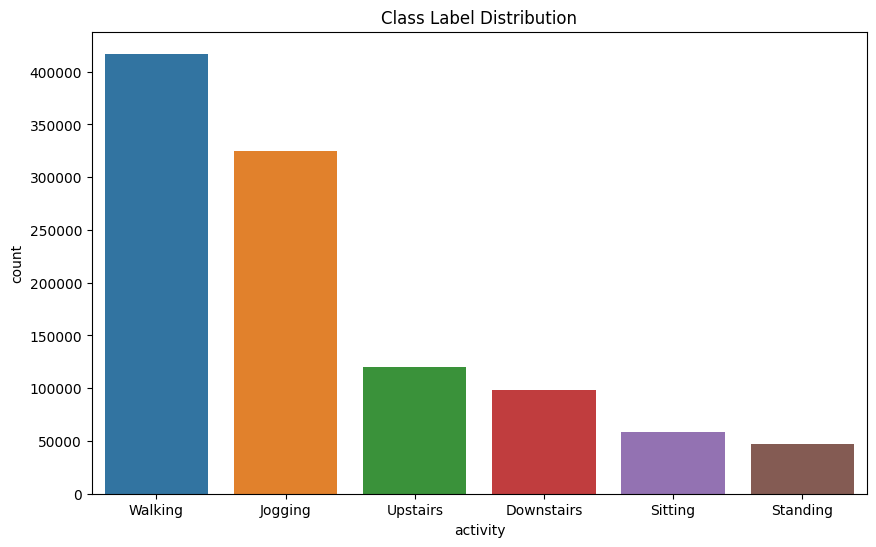

In [69]:
# Class Label Distribution SNS plot
plt.figure(figsize=(10, 6))
sns.countplot(x= "activity", data = df)
plt.title("Class Label Distribution")
plt.show()



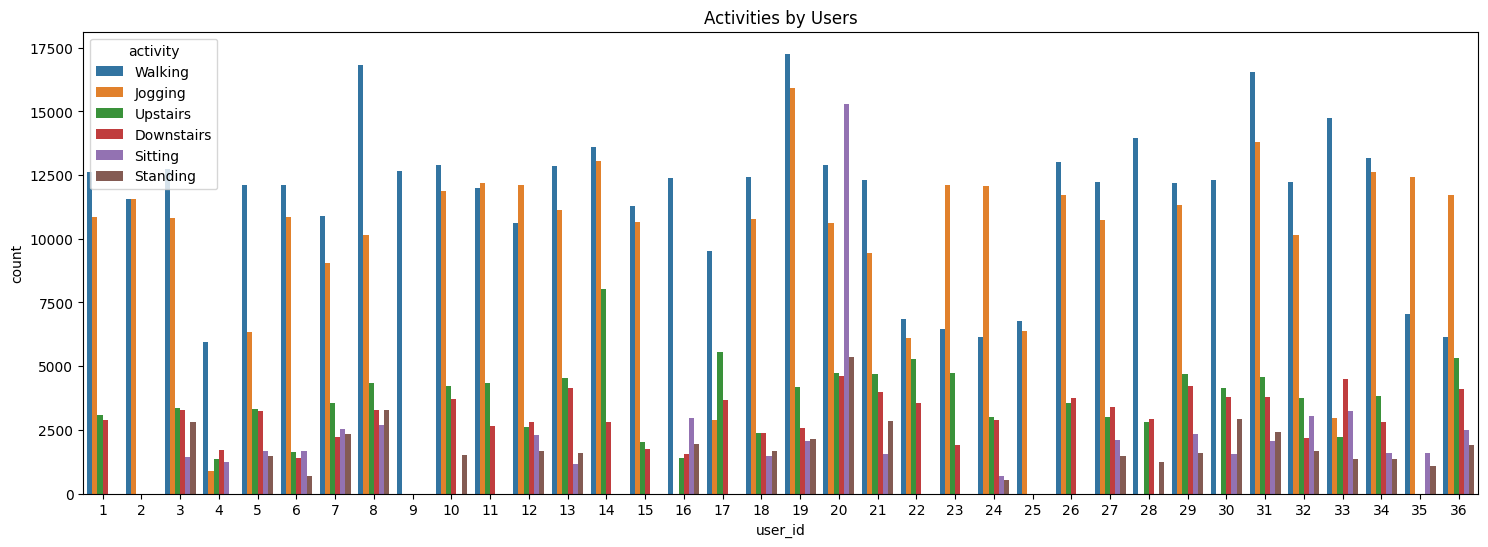

In [72]:
# Highly unbalanced dataset - Order (walking, jogging, upstairs, downstairs, sitting, standing)
# User plot

plt.figure(figsize = (18, 6))
sns.countplot(x = "user_id", hue = "activity", data = df)
plt.title("Activities by Users")
plt.show()

In [81]:
# Find i where all the activities are present
user_ids = df["user_id"].unique()
user_list = []
for user in user_ids:
    activities = df[df["user_id"] == user]["activity"].unique()
    if len(activities) == 6:
        user_list.append(user)
    

In [82]:
print("Users with all the activities: ", user_list)

Users with all the activities:  [3, 5, 6, 7, 8, 12, 13, 18, 19, 20, 21, 24, 27, 29, 31, 32, 33, 34, 36]


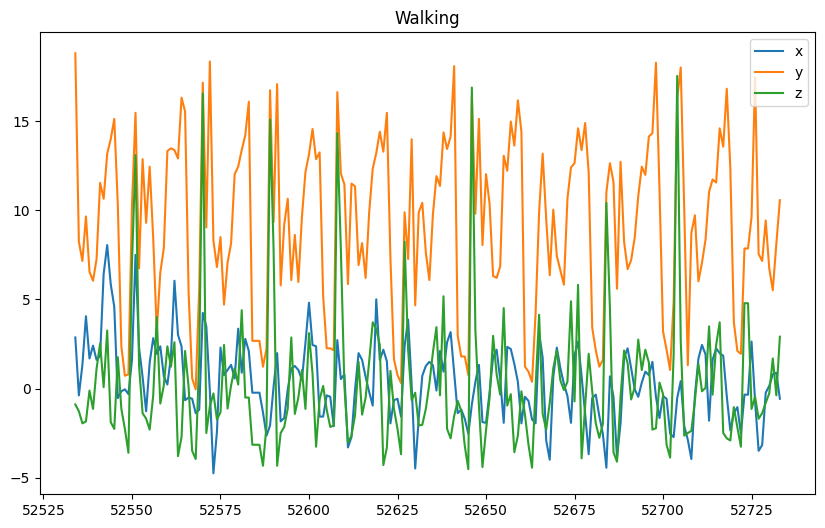

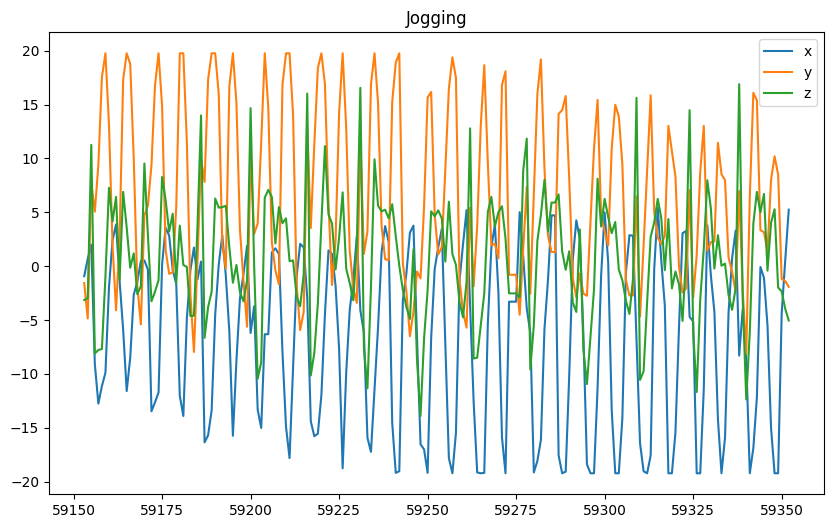

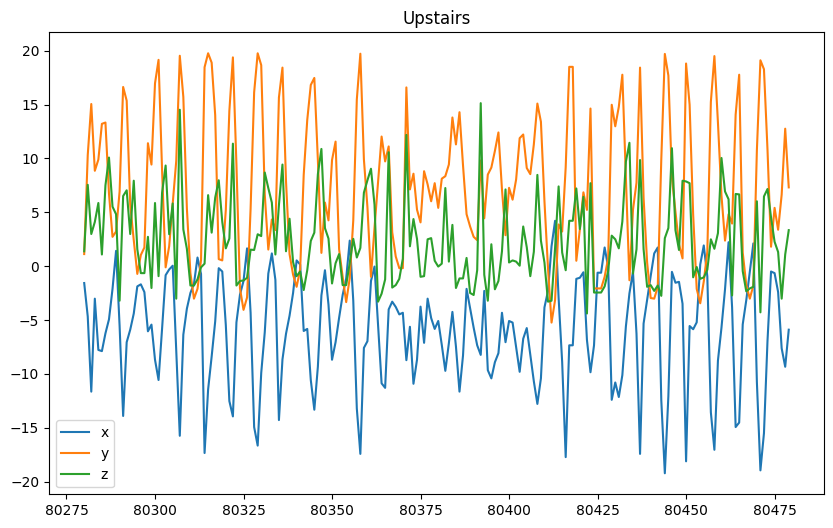

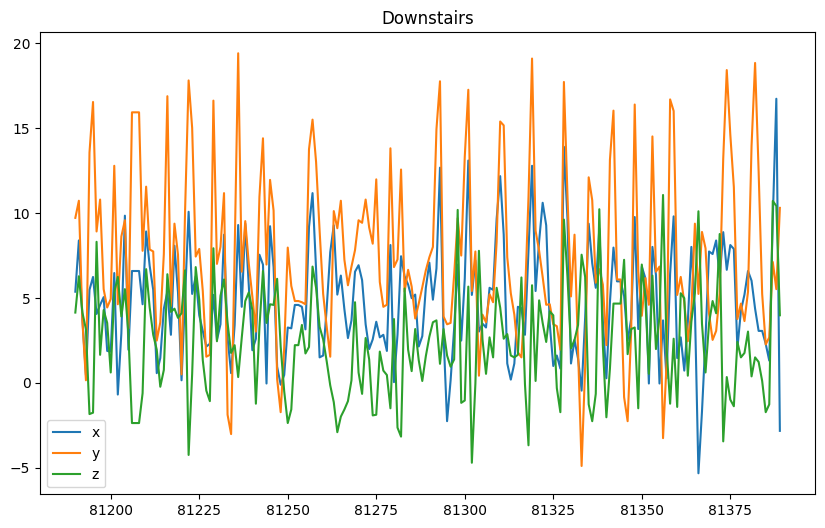

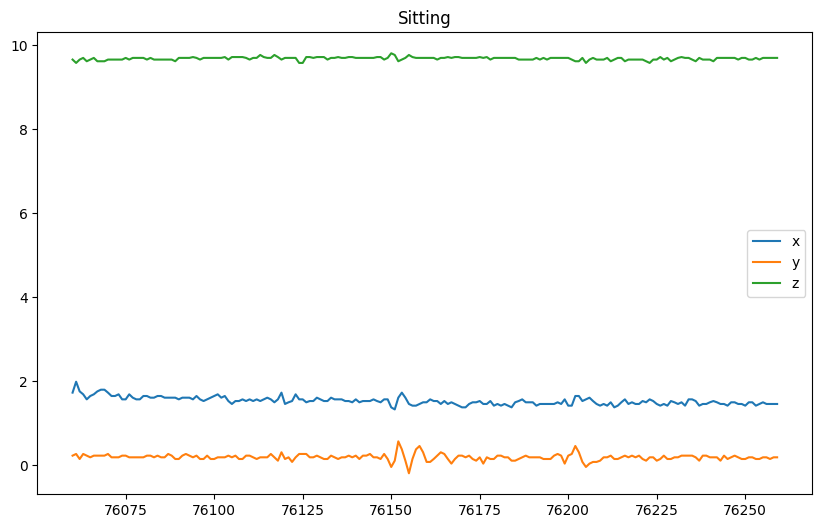

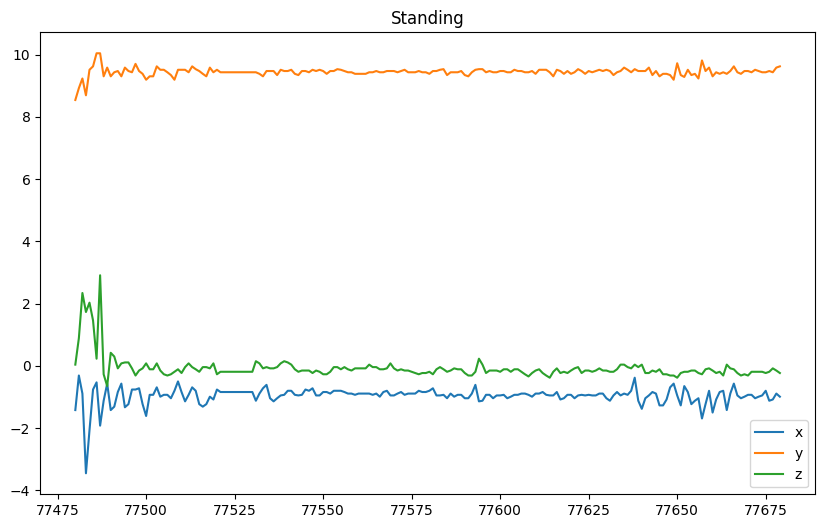

In [86]:
# Each user have different contribution - Some users have more data for some activities and some have less

# Observe the data for a single user and plot time series data for a single user

classes = df["activity"].unique()
user_id = 3
sampling_length = 200
for i in classes:
    plt.figure(figsize=(10, 6))
    plt.title(i)
    plt.plot(df[(df["user_id"] == user_id) & (df["activity"] == i)].x[:sampling_length], label = "x")
    plt.plot(df[(df["user_id"] == user_id) & (df["activity"] == i)].y[:sampling_length], label = "y")
    plt.plot(df[(df["user_id"] == user_id) & (df["activity"] == i)].z[:sampling_length], label = "z")
    plt.legend()
    plt.show()



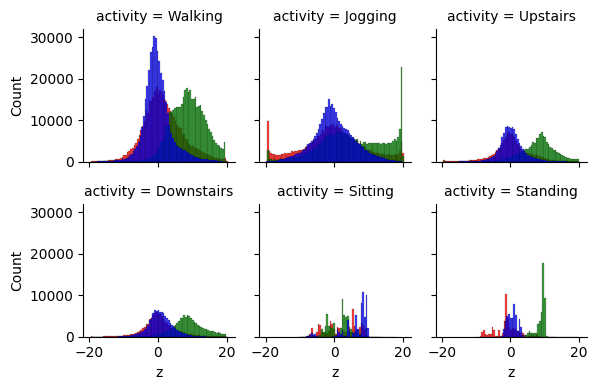

In [102]:
# Understanding the data using Facet plots
# Facet Grid
g = sns.FacetGrid(df, col = "activity", col_wrap = 3, height = 2)

# Map distplot to each subplot for x, y, z
g.map(sns.histplot, "x", color = "r", binwidth = 0.5)
g.map(sns.histplot, "y", color = "g", binwidth = 0.5)
g.map(sns.histplot, "z", color = "b", binwidth = 0.5)

g.add_legend()
plt.show()


In [103]:
# Above we can see  
# 1. Walking, Jogging, Upstairs and Downstairs have difference in (x,z) peak and y distribution peak
# 2. For sitting and Standing it is hard to tell a value but for sitting the z peak is higher than x and y and for standing y peak is higher than x and z

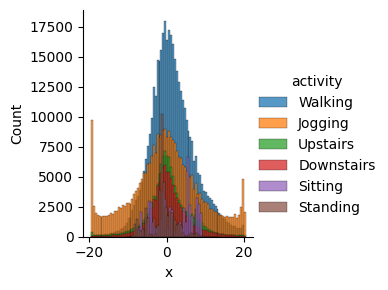

In [118]:
g = sns.FacetGrid(df, hue = "activity")

# Map distplot to each subplot for x, y, z
g.map(sns.histplot, "x",binwidth = 0.5)
g.add_legend()
plt.show()

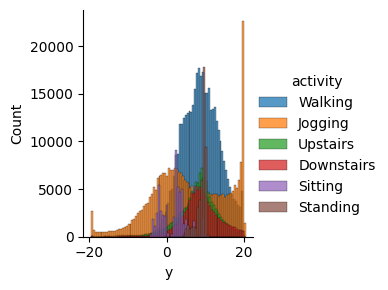

In [120]:
g = sns.FacetGrid(df, hue = "activity")

# Map distplot to each subplot for x, y, z
g.map(sns.histplot, "y",binwidth = 0.5)
g.add_legend()
plt.show()

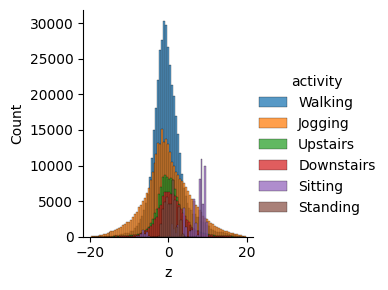

In [121]:
g = sns.FacetGrid(df, hue = "activity")

# Map distplot to each subplot for x, y, z
g.map(sns.histplot, "z",binwidth = 0.5)
g.add_legend()
plt.show()

In [ ]:
# Above 3 plots conclusion
# 1. Sitting is having distinct peak in z axis
# 2. All distributions having so much overlap hard to understand anything 